In [23]:
#importing everything
import matplotlib.pyplot as plt
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import pandas as pd
import praw
import requests
import json
from datetime import date, timedelta
from keras import layers
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score
from pandas.plotting import register_matplotlib_converters

In [24]:
register_matplotlib_converters()

## Financial Data

In [25]:
# ticker of the stock we wish to analyze
ticker = "AAPL"
# use the Yahoo Finance api to download price data
stock = yf.download(ticker, start='2018-01-01', end='2020-12-31', interval="1d").dropna()
# display the fetched data
stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.248276,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.241093,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.432652,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.904381,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.748741,82271200
...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.347565,88223700
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.352844,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,136.050781,124486200


## SMA Example

In [26]:
# compute SMAs
stock['2_SMA'] = stock['Close'].rolling(window=2).mean()
stock['5_SMA'] = stock['Close'].rolling(window=5).mean()
stock = stock.dropna()
# SMA trade calls
trade_buy=[]
trade_sell=[]
for i in range(len(stock)-1):
# if the 2-day SMA crosses over the 5-day SMA, we make a buy call
    if ((stock['2_SMA'].values[i] < stock['5_SMA'].values[i]) & (stock['2_SMA'].values[i+1] > stock['5_SMA'].values[i+1])):
        trade_buy.append(i+1)
# if the opposite happens, we make a sell call
    elif ((stock['2_SMA'].values[i] > stock['5_SMA'].values[i]) & (stock['2_SMA'].values[i+1] < stock['5_SMA'].values[i+1])):
        trade_sell.append(i+1)

C:\Users\jrese\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jrese\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jrese\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\jrese\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

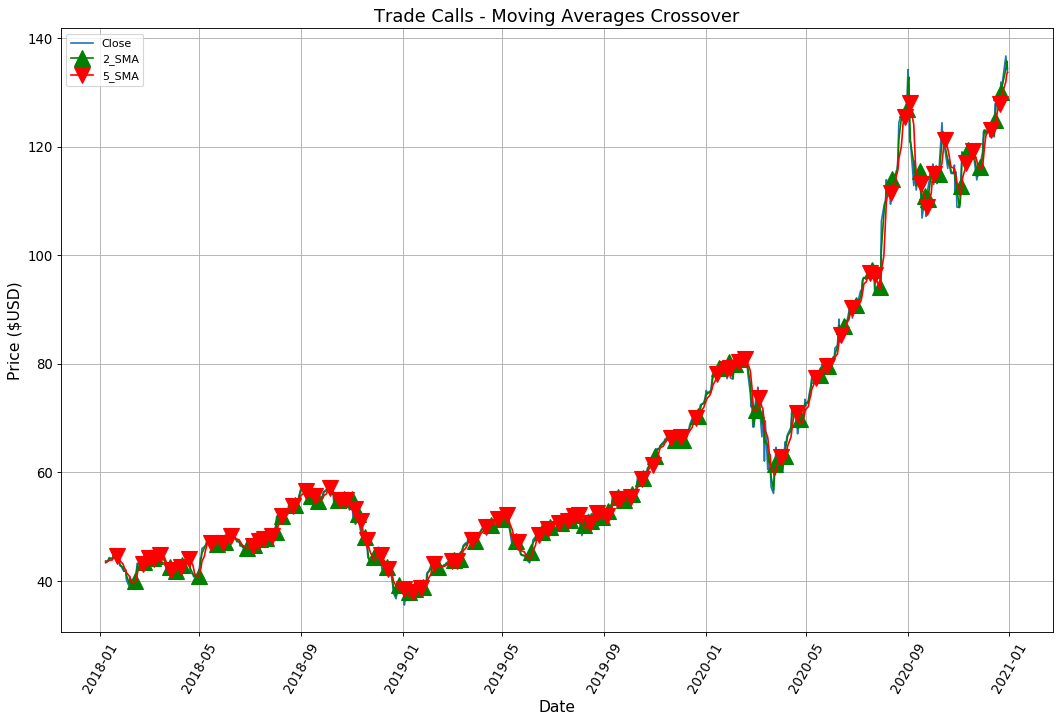

In [27]:
plt.figure(figsize=(16, 10),dpi=80)
plt.plot(stock.index, stock['Close'])
plt.plot(stock.index, stock['2_SMA'],'-^', markevery=trade_buy, ms=15, color='green')
plt.plot(stock.index, stock['5_SMA'],'-v', markevery=trade_sell, ms=15,color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price ($USD)', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - Moving Averages Crossover', fontsize = 16)
plt.legend(['Close','2_SMA','5_SMA'])
plt.grid()
plt.show()


In [28]:
correct_buy = 0
for buy_signal in trade_buy:
    price_before = stock['Close'].iloc[buy_signal]
    price_after = stock['Close'].iloc[buy_signal + 1]
    if price_after > price_before:
        correct_buy += 1

        
correct_sell = 0
for sell_signal in trade_sell:
    price_before = stock['Close'].iloc[sell_signal]
    price_after = stock['Close'].iloc[sell_signal + 1]
    if price_after > price_before:
        correct_sell += 1
        
        
print("Correct buy call percentage:")
print((correct_buy / len(trade_buy)) * 100)
print()
print("Correct sell call percentage:")
print((correct_sell / len(trade_sell)) * 100)
print()
print("Overall correct trade calls percentage:")
print(((correct_sell + correct_buy) / (len(trade_sell) + len(trade_buy))) * 100)


Correct buy call percentage:
52.5

Correct sell call percentage:
68.75

Overall correct trade calls percentage:
60.62499999999999


## Scraping from Reddit

In [29]:
ticker = "AAPL"

In [30]:
all_data = []
# start of 2018 to end of 2020
from_date = 1514793600 
to_date = 1609401600
last_created = from_date

# we make repeated requests, since the limit per request is only 500 posts
while last_created < to_date:
    raw_data = requests.get("https://api.pushshift.io/reddit/search/submission/?q={}&after={}&size={}".format(ticker,
                                                                                                             last_created,
                                                                                                             to_date,
                                                                                                             "500"
                                                                                                            ))
    
    # guard against timeouts
    try:
        data = json.loads(raw_data.text)
        all_data += data['data']
        last_created = int(all_data[-1]['created_utc'])
    except:
        if raw_data.status_code == 522:
            time.sleep(4)
            print("Timed out, continuing")
        
    print("Last date fetched:", date.fromtimestamp(all_data[-1]['created_utc']))

Last date fetched: 2018-01-17
Last date fetched: 2018-01-29
Last date fetched: 2018-02-02
Last date fetched: 2018-02-15
Last date fetched: 2018-03-05
Last date fetched: 2018-03-23
Last date fetched: 2018-04-18
Last date fetched: 2018-05-01
Last date fetched: 2018-05-11
Last date fetched: 2018-06-04
Last date fetched: 2018-06-20
Last date fetched: 2018-07-10
Last date fetched: 2018-07-19
Last date fetched: 2018-07-31
Last date fetched: 2018-08-02
Last date fetched: 2018-08-10
Last date fetched: 2018-08-20
Last date fetched: 2018-08-31
Last date fetched: 2018-09-10
Last date fetched: 2018-09-17
Last date fetched: 2018-09-26
Last date fetched: 2018-10-04
Last date fetched: 2018-10-12
Last date fetched: 2018-10-26
Last date fetched: 2018-11-01
Last date fetched: 2018-11-02
Last date fetched: 2018-11-03
Last date fetched: 2018-11-04
Last date fetched: 2018-11-04
Last date fetched: 2018-11-04
Last date fetched: 2018-11-04
Last date fetched: 2018-11-04
Last date fetched: 2018-11-04
Last date 

In [31]:
# extract the text and date created from posts and put into a dataframe
text_post = [post.get('selftext') for post in all_data if post.get('selftext', None)]
dates = [date.fromtimestamp(post['created_utc']) for post in all_data if post.get('selftext', None)]
ids = [post['id'] for post in all_data if post.get('selftext', None)]
pd_data = {'publishedAt':dates, 'text':text_post, 'id': ids}

df = pd.DataFrame(pd_data)
df.drop_duplicates(inplace=True)

df

,publishedAt,text,id
0,2018-01-01,Looking at AAPLs fundamentals and the pile of ...,7nhc2r
1,2018-01-01,I’ve decided I’m most likely interested in jus...,7nhwud
2,2018-01-01,I’ve decided I’m most likely interested in jus...,7ni0o7
3,2018-01-01,Today is 1-1-2018.\n\nThese are my calls for 1...,7ni2nx
4,2018-01-01,Today is 1-1-2018.\n\nThese are my calls for 1...,7ni2wv
...,...,...,...
9444,2020-12-31,12.31.2020 $SPY\n\n* Change @ +0.51%\n* Open @...,knzw3e
9445,2020-12-31,My script is using data from the finnhub [api]...,ko098y
9446,2021-01-01,Hi all. I 've for a couple of days trying to i...,ko1i7w
9447,2021-01-01,Hi just putting out the Titanvest holdings if ...,ko1od8


## Using sentiment Analysis

In [32]:
# initialize VADER
analyzer = SentimentIntensityAnalyzer()
df.sort_values(by='publishedAt',inplace=True)
# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay
# to get the business day for which particular post should be used to make trade calls (since
# the stock market only opens on certain days)

def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    # decide whether the sentiment should be used for the current
    # open date or for the next open date for the stock market
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
    
# apply the above function to get the trading time for each post
df["trading_time"] = df["publishedAt"].apply(get_trade_open)
final_wsb_data = df[pd.notnull(df['trading_time'])]
final_wsb_data['Date'] = pd.to_datetime(pd.to_datetime(final_wsb_data['trading_time']).dt.date)

In [33]:
# assigning a compound sentiment score to each post
cs = []
for row in range(len(final_wsb_data)):
    cs.append(analyzer.polarity_scores(final_wsb_data['text'].iloc[row])['compound'])
    
final_wsb_data['compound_vader_score'] = cs
final_wsb_data = final_wsb_data[(final_wsb_data[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

In [34]:
final_wsb_data

,publishedAt,text,id,trading_time,Date,compound_vader_score
0,2018-01-01,Looking at AAPLs fundamentals and the pile of ...,7nhc2r,2018-01-01 13:30:00,2018-01-01,0.9772
1,2018-01-01,I’ve decided I’m most likely interested in jus...,7nhwud,2018-01-01 13:30:00,2018-01-01,0.8919
2,2018-01-01,I’ve decided I’m most likely interested in jus...,7ni0o7,2018-01-01 13:30:00,2018-01-01,0.8919
3,2018-01-01,Today is 1-1-2018.\n\nThese are my calls for 1...,7ni2nx,2018-01-01 13:30:00,2018-01-01,-0.8402
4,2018-01-01,Today is 1-1-2018.\n\nThese are my calls for 1...,7ni2wv,2018-01-01 13:30:00,2018-01-01,-0.8402
...,...,...,...,...,...,...
7806,2020-12-31,The reason I’m asking is because when the disc...,knnc52,2020-12-31 13:30:00,2020-12-31,0.8390
7807,2020-12-31,Watchlist 12-31-20 👀\n\nStock futures opened f...,knhtbi,2020-12-31 13:30:00,2020-12-31,0.9862
7808,2021-01-01,Hi just putting out the Titanvest holdings if ...,ko1od8,2021-01-01 13:30:00,2021-01-01,0.9984
7809,2021-01-01,Hi all. I 've for a couple of days trying to i...,ko1i7w,2021-01-01 13:30:00,2021-01-01,-0.9223


In [35]:
stock_aug = stock.copy()
polarity_lag = 3
polarities = {f"polarity_{idx}": [] for idx in range(polarity_lag)}

returns = []
for row in range(len(stock)):
    date = stock.index[row].date()
    polarities_row = []
    
    for i in range(3):
        polarity = np.mean(
            final_wsb_data[
                final_wsb_data['Date'] == (date - timedelta(days=i))][
                'compound_vader_score']
        )

    
        if np.isnan(polarity):
            polarity = 0
            
        polarities_row.append(polarity)
        
    for idx, polarity in enumerate(polarities_row):
        polarities[f"polarity_{idx}"].append(polarity)
    try:
        today_price = stock.iloc[row]['Close']
        tomorrow_price = stock.iloc[row + 1]['Close']
        return_perc = ((tomorrow_price - today_price) / today_price) * 100
        
        if return_perc < 0:
            returns.append(0)
        else:
            returns.append(1)
    except:
        returns.append(0)
            
            
stock_aug['direction'] = returns

for polarity_key, value in polarities.items():
    stock_aug[polarity_key] = value


In [36]:
stock_aug

,Open,High,Low,Close,Adj Close,Volume,2_SMA,5_SMA,direction,polarity_0,polarity_1,polarity_2
Date,,,,,,,,,,,,
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.748741,82271200,43.668751,43.343500,0,0,0,0
2018-01-09,43.637501,43.764999,43.352501,43.582500,41.743954,86336000,43.585001,43.447000,0,0,0,0
2018-01-10,43.290001,43.575001,43.250000,43.572498,41.734364,95839600,43.577499,43.550000,1,0,0,0
2018-01-11,43.647499,43.872501,43.622501,43.820000,41.971424,74670800,43.696249,43.662500,1,0,0,0
2018-01-12,44.044998,44.340000,43.912498,44.272499,42.404839,101672400,44.046249,43.767000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.347565,88223700,131.420006,129.286002,1,0,0,0
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.352844,54930100,131.465004,129.940002,1,0,0,0
2020-12-28,133.990005,137.339996,133.509995,136.690002,136.050781,124486200,134.330002,131.946002,0,0,0,0


## Testing

In [37]:
X_data = stock_aug[['2_SMA', '5_SMA', 'polarity_0', 'polarity_1', 'polarity_2']].to_numpy()
y_data = stock_aug['direction'].to_numpy()

# split into train and test
TRAIN_SIZE = 0.8
obs = len(X_data)
X_train, X_test = X_data[:int(obs * TRAIN_SIZE)], X_data[int(obs * TRAIN_SIZE):]
y_train, y_test = y_data[:int(obs * TRAIN_SIZE)], y_data[int(obs * TRAIN_SIZE):]

In [38]:
up_days = sum(y_train)
print("Expected accuracy if we were randomly guessing:")
print(up_days / len(y_train))

Expected accuracy if we were randomly guessing:
0.54


In [39]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
print("Training score using logistic regression:")
print(clf.score(X_train, y_train))
print()
print("Test score using logistic regression:")
print(clf.score(X_test, y_test))

Training score using logistic regression:
0.54

Test score using logistic regression:
0.5695364238410596


C:\Users\jrese\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
def create_model():
    model = Sequential()
    model.add(Dense(6, input_dim=5, activation="relu"))
    model.add(Dense(6, activation="relu"))
    model.add(Dense(6, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def train_and_evaluate_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=50, verbose=0)
    score = model.evaluate(x_train, y_train, verbose=0)
    return score


nn_scores_training = []
nn_scores_test = []
n_tries = 10

# we train 10 different neural networks to account for random initialization and variation
for i in range(n_tries):
    print("Running training set", i+1, "/", n_tries)
    model = None # Clearing the NN.
    model = create_model()
    score = train_and_evaluate_model(model, X_train, y_train)
    nn_scores_training.append(score)
    nn_scores_test.append(model.evaluate(X_test, y_test, verbose=0))

print("Final training score:")
print(np.mean(nn_scores_training))
print()
print("Test score:")
print(np.mean(nn_scores_test))


Running training set 1 / 10
Running training set 2 / 10
Running training set 3 / 10
Running training set 4 / 10
Running training set 5 / 10
Running training set 6 / 10
Running training set 7 / 10
Running training set 8 / 10
Running training set 9 / 10
Running training set 10 / 10
Final training score:
0.6089216977357864

Test score:
0.6178106069564819


C:\Users\jrese\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


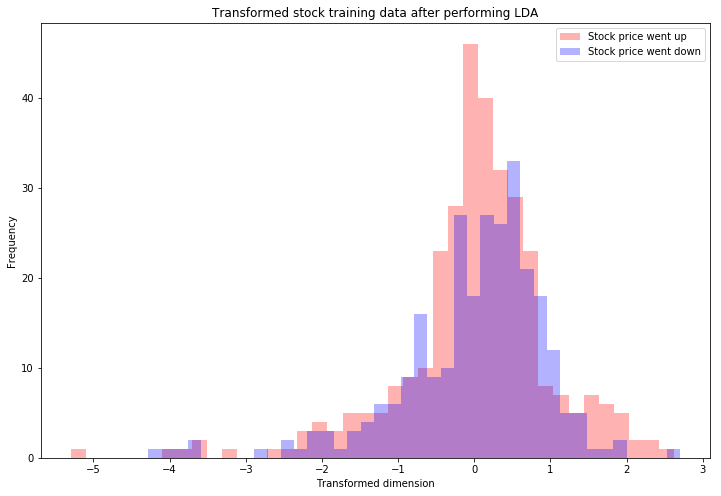

In [41]:
lda_repr = LDA(n_components=1)
X_train_trans = lda_repr.fit_transform(X_train, y_train)
plt.figure(figsize=(12, 8))
plt.hist(X_train_trans[y_train == 1], bins=40, alpha=0.3, color='red', label="Stock price went up")
plt.hist(X_train_trans[y_train == 0], bins=40, alpha=0.3, color='blue', label="Stock price went down")
plt.legend()
plt.xlabel("Transformed dimension")
plt.ylabel("Frequency")
plt.title("Transformed stock training data after performing LDA")
plt.show()